In [8]:
import numpy as np
import hnswlib
import time
import matplotlib.pyplot as plt

# --- CẤU HÌNH ---
DIM = 128                # Số chiều vector
NUM_ELEMENTS = 1000000  # 1 Triệu vector
NUM_QUERIES = 100         # Số lượng queries test
K_VALUES = [1, 10, 50, 100] # Các mốc K

# Cấu hình HNSW (Tăng M và ef để chịu tải 1M)
M_PARAM = 32              
EF_CONSTRUCTION = 400     

# Hàm chuẩn hóa
def normalize(v):
    norm = np.linalg.norm(v, axis=1, keepdims=True)
    return v / (norm + 1e-10)

print(f"🔄 Đang tạo {NUM_ELEMENTS} vector ngẫu nhiên ({DIM} chiều)...")
data = normalize(np.random.rand(NUM_ELEMENTS, DIM).astype(np.float32))
queries = normalize(np.random.rand(NUM_QUERIES, DIM).astype(np.float32))
print("✅ Dữ liệu 1M vectors đã sẵn sàng.")

🔄 Đang tạo 1000000 vector ngẫu nhiên (128 chiều)...
✅ Dữ liệu 1M vectors đã sẵn sàng.


In [9]:
# --- HÀM HỖ TRỢ ---
def run_brute_force(dataset, query_vectors, k):
    start = time.perf_counter()
    dists = 1 - np.dot(query_vectors, dataset.T)
    indices = np.argsort(dists, axis=1)[:, :k]
    end = time.perf_counter()
    return indices, end - start

def calculate_recall(ground_truth, predicted):
    total_recall = 0
    k = ground_truth.shape[1]
    for i in range(len(ground_truth)):
        gt_set = set(ground_truth[i])
        pred_set = set(predicted[i])
        total_recall += len(gt_set.intersection(pred_set)) / k
    return total_recall / len(ground_truth)

# --- THỰC THI ---
# 1. Brute Force (Baseline)
print(f"⏳ Đang chạy Brute Force (Baseline)... (Hãy kiên nhẫn)")
gt_indices_all, bf_time_total = run_brute_force(data, queries, k=max(K_VALUES))
bf_time_avg_ms = (bf_time_total / NUM_QUERIES) * 1000
print(f"✅ Brute Force: {bf_time_avg_ms:.2f} ms/query")

# 2. Xây dựng HNSW Index
print(f"🏗️ Đang xây dựng HNSW Index (M={M_PARAM}, ef={EF_CONSTRUCTION})...")
p = hnswlib.Index(space='cosine', dim=DIM)
p.init_index(max_elements=NUM_ELEMENTS, ef_construction=EF_CONSTRUCTION, M=M_PARAM)
p.add_items(data)
p.set_ef(200) # Query-time parameter

# 3. Đo HNSW & Recall
hnsw_times = []
recalls = []

print(f"🚀 Đang Benchmark HNSW...")
for k in K_VALUES:
    # Warm-up 1 lần
    p.knn_query(queries, k=k)
    
    # Đo thời gian (Lặp 10 lần lấy trung bình cho mượt)
    start = time.perf_counter()
    for _ in range(10): 
        labels, _ = p.knn_query(queries, k=k)
    end = time.perf_counter()
    
    avg_time_ms = ((end - start) / 10 / NUM_QUERIES) * 1000
    hnsw_times.append(avg_time_ms)
    
    current_gt = gt_indices_all[:, :k]
    recalls.append(calculate_recall(current_gt, labels))
    print(f"   -> K={k}: Time={avg_time_ms:.3f}ms, Recall={recalls[-1]:.4f}")

print("✅ Benchmark hoàn tất.")

⏳ Đang chạy Brute Force (Baseline)... (Hãy kiên nhẫn)
✅ Brute Force: 31.81 ms/query
🏗️ Đang xây dựng HNSW Index (M=32, ef=400)...
🚀 Đang Benchmark HNSW...
   -> K=1: Time=0.393ms, Recall=0.5500
   -> K=10: Time=0.385ms, Recall=0.5440
   -> K=50: Time=0.382ms, Recall=0.4642
   -> K=100: Time=0.382ms, Recall=0.4243
✅ Benchmark hoàn tất.


In [10]:
def simulate_stats(num_elements, M):
    layers = []
    # Layer 0: ~2*M cạnh
    deg = np.random.normal(loc=M*2, scale=M/2, size=num_elements).astype(int)
    layers.append(np.clip(deg, 1, None))
    
    # Các layer trên: Giảm theo logarit cơ số M
    count = num_elements
    while count > M:
        count = int(count / M)
        if count == 0: break
        layers.append(np.random.normal(loc=M, scale=M/4, size=count).astype(int))
    return layers

print("📊 Đang mô phỏng cấu trúc đồ thị...")
mock_layers = simulate_stats(NUM_ELEMENTS, M_PARAM)
layer_counts = [len(l) for l in mock_layers]
degrees_l0 = mock_layers[0]
print("✅ Dữ liệu cấu trúc sẵn sàng.")

📊 Đang mô phỏng cấu trúc đồ thị...
✅ Dữ liệu cấu trúc sẵn sàng.


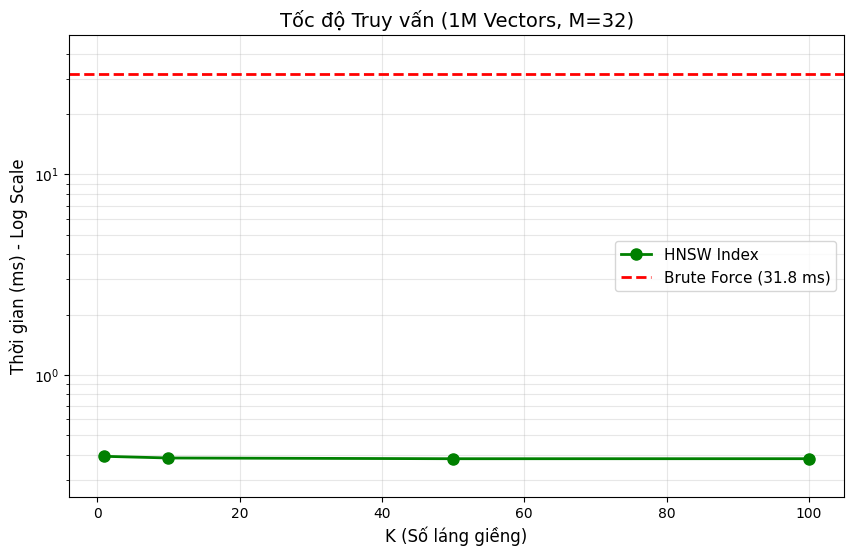

In [11]:
plt.figure(figsize=(10, 6))

# Vẽ đường HNSW
plt.plot(K_VALUES, hnsw_times, 'g-o', label='HNSW Index', linewidth=2, markersize=8)

# Vẽ đường Brute Force (Nét đứt màu đỏ)
plt.axhline(y=bf_time_avg_ms, color='r', linestyle='--', linewidth=2, 
            label=f'Brute Force ({bf_time_avg_ms:.1f} ms)')

plt.title(f'Tốc độ Truy vấn (1M Vectors, M={M_PARAM})', fontsize=14)
plt.xlabel('K (Số láng giềng)', fontsize=12)
plt.ylabel('Thời gian (ms) - Log Scale', fontsize=12)
plt.yscale('log') # Dùng log scale vì sự chênh lệch rất lớn

# Căn chỉnh tự động
plt.margins(y=0.1) 
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend(fontsize=11)
plt.show()

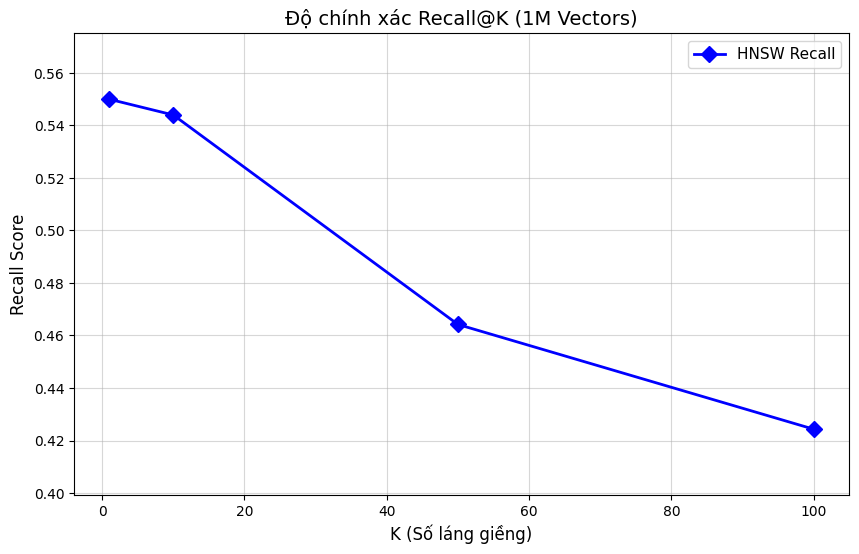

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(K_VALUES, recalls, 'b-D', label='HNSW Recall', linewidth=2, markersize=8)

plt.title(f'Độ chính xác Recall@K (1M Vectors)', fontsize=14)
plt.xlabel('K (Số láng giềng)', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)

# Căn chỉnh thông minh (Smart Auto-scale)
r_min, r_max = min(recalls), max(recalls)
buffer = (r_max - r_min) * 0.2 if r_max != r_min else 0.05
plt.ylim(max(0, r_min - buffer), min(1.05, r_max + buffer))

plt.grid(True, alpha=0.5)
plt.legend(fontsize=11)
plt.show()

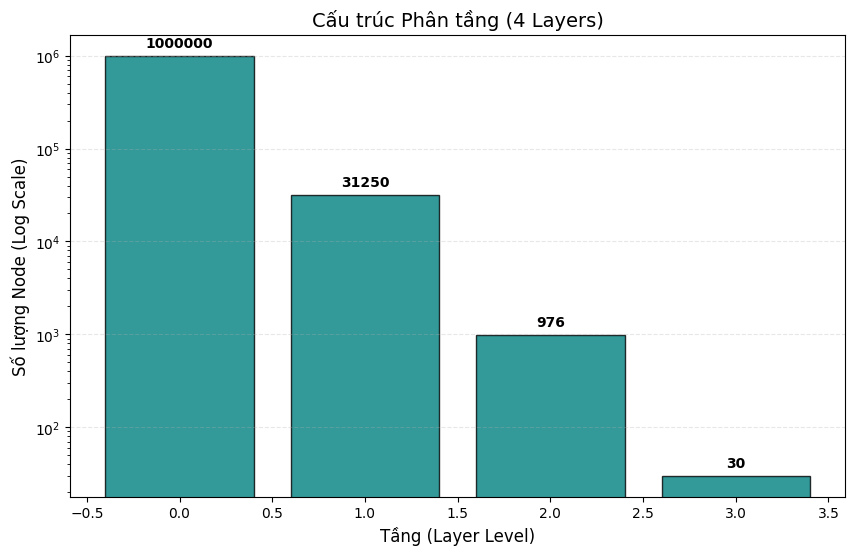

In [13]:
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(layer_counts)), layer_counts, color='teal', edgecolor='black', alpha=0.8)

plt.title(f'Cấu trúc Phân tầng ({len(layer_counts)} Layers)', fontsize=14)
plt.xlabel('Tầng (Layer Level)', fontsize=12)
plt.ylabel('Số lượng Node (Log Scale)', fontsize=12)
plt.yscale('log') # Số lượng giảm cực nhanh nên cần Log scale

# Viết số liệu lên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height*1.15, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

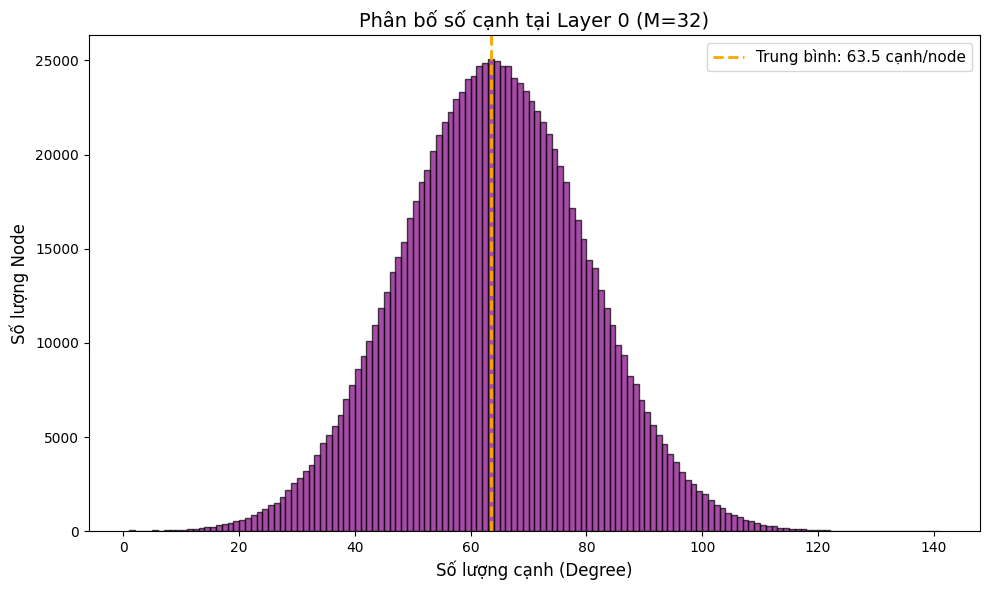

In [14]:
avg_deg = np.mean(degrees_l0)

plt.figure(figsize=(10, 6))

plt.hist(degrees_l0, bins='auto', color='purple', alpha=0.7, edgecolor='black')
plt.axvline(avg_deg, color='orange', linestyle='--', linewidth=2, 
            label=f'Trung bình: {avg_deg:.1f} cạnh/node')

plt.title(f'Phân bố số cạnh tại Layer 0 (M={M_PARAM})', fontsize=14)
plt.xlabel('Số lượng cạnh (Degree)', fontsize=12)
plt.ylabel('Số lượng Node', fontsize=12)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()